In [1]:
import cv2
from ultralytics import YOLO
#import numpy as np
import matplotlib.pyplot as plt


In [15]:
model = YOLO("best.pt")

In [16]:
# Path to your test image (change this to your own image path)
image_path = "car.png"

# Run detection
results = model(image_path, conf=0.25)  # confidence threshold 50%

# results[0] contains detections for the first (and only) image
results[0].show()   # OpenCV popup (if supported)


image 1/1 c:\Users\cedri\Documents\GitHub\dspCPE4A2526\dspPython\Activity 9\car.png: 416x640 1 license-plate, 110.8ms
Speed: 1.6ms preprocess, 110.8ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


In [7]:
pip install  pytesseract

Note: you may need to restart the kernel to use updated packages.


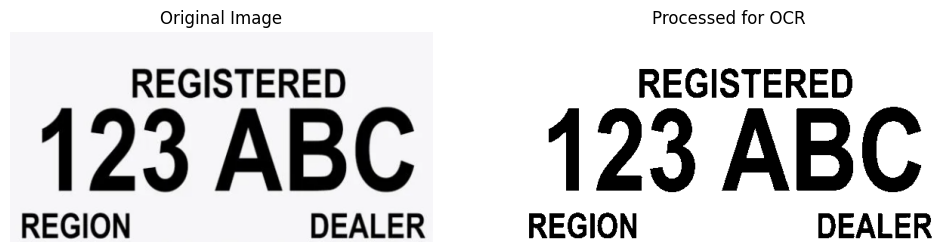

Extracted Text:
 REGISTERED

123 ABC

REGION DEALER



In [13]:
import cv2
import pytesseract
from matplotlib import pyplot as plt

# --- OPTIONAL: If tesseract is not in PATH, set the path manually ---
# For Windows, uncomment and adjust:
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

def ocr_image(image_path):
    # Load the image
    img = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply thresholding
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

    # Morphological noise removal
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # OCR with Tesseract
    text = pytesseract.image_to_string(cleaned)

    # Show original and processed image inline (Jupyter)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(cleaned, cmap="gray")
    axs[1].set_title("Processed for OCR")
    axs[1].axis("off")

    plt.show()

    return text


# Example usage
text_output = ocr_image("imageSample.png")
print("Extracted Text:\n", text_output)


Showing YOLO detection result...

Running complete license plate recognition pipeline...

image 1/1 c:\Users\cedri\Documents\GitHub\dspCPE4A2526\dspPython\Activity 9\car.png: 416x640 1 license-plate, 84.8ms
Speed: 1.6ms preprocess, 84.8ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


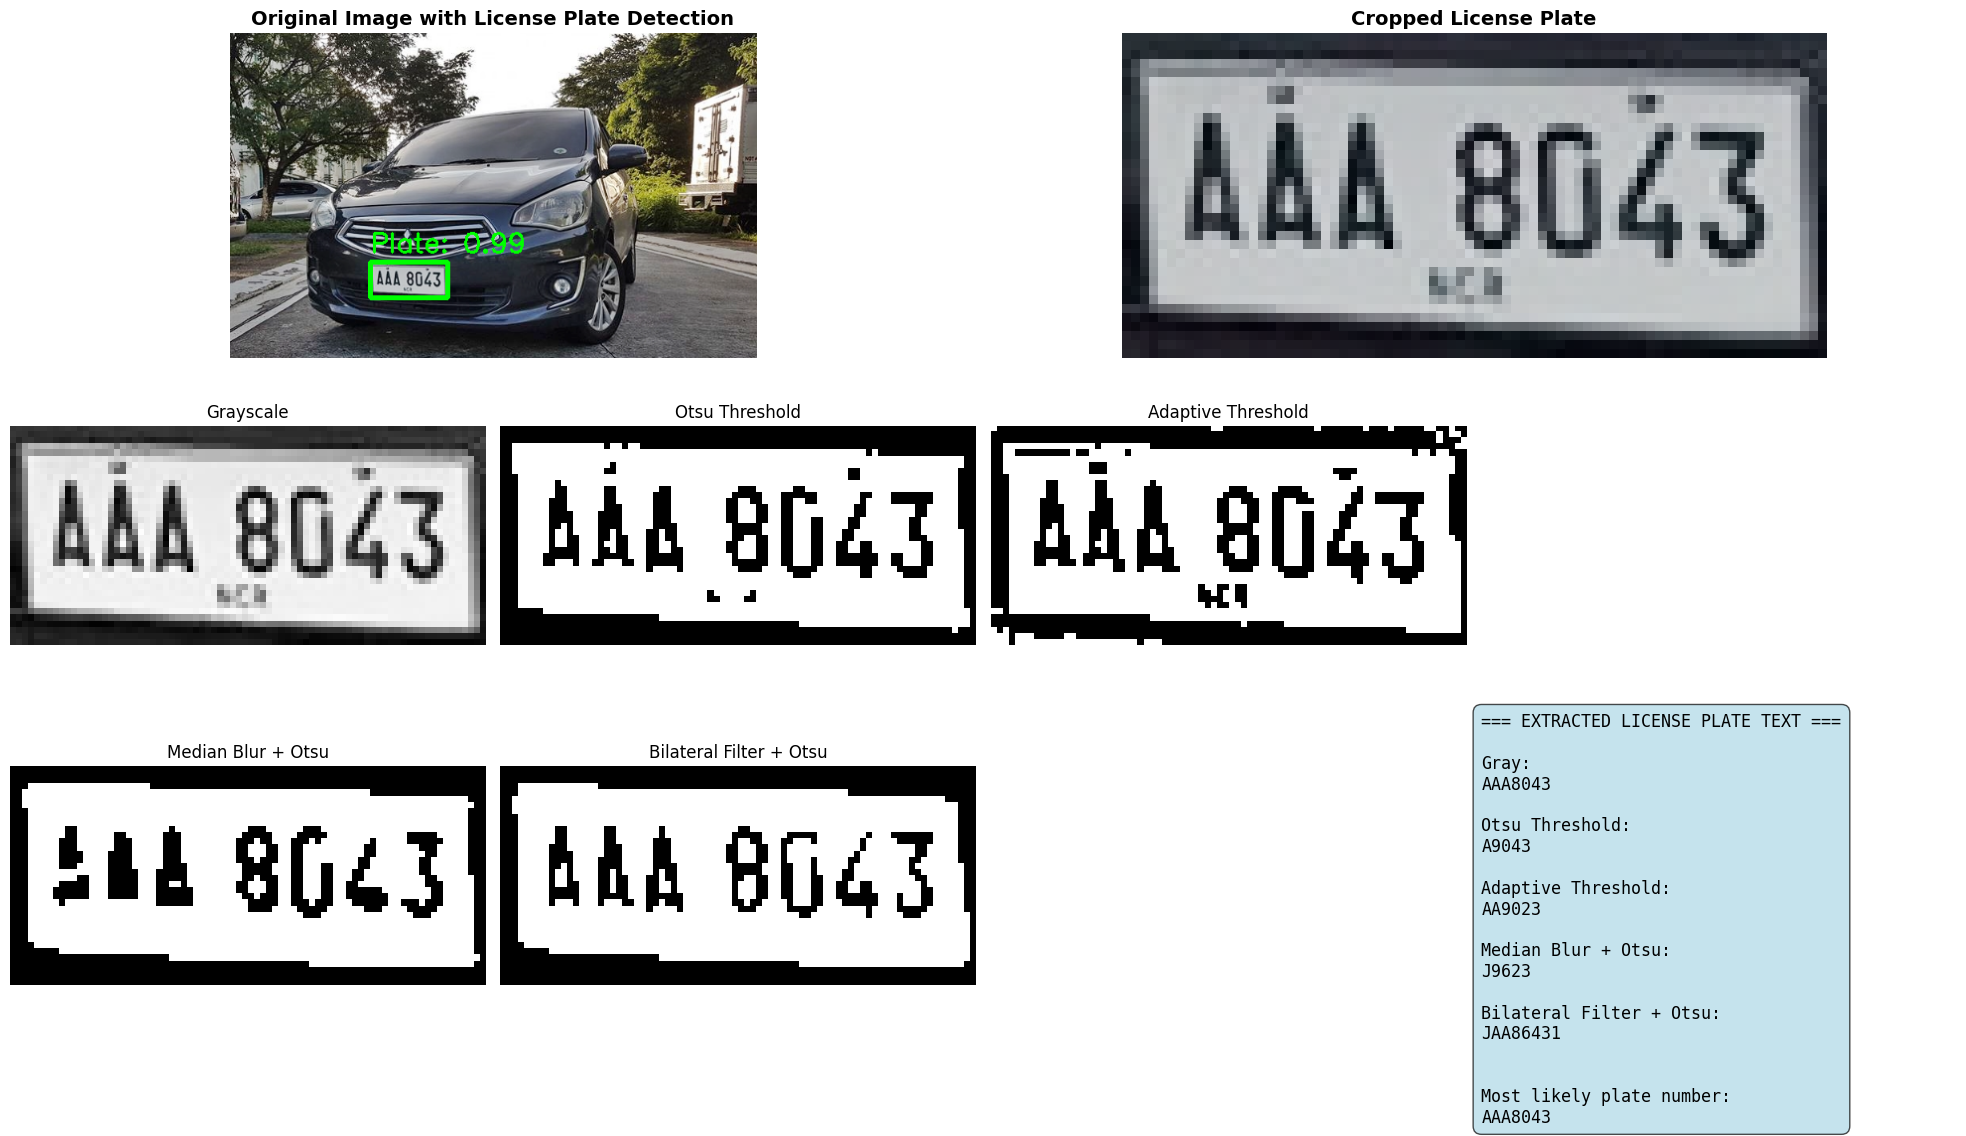


LICENSE PLATE RECOGNITION RESULTS
Gray: AAA8043
Otsu Threshold: A9043
Adaptive Threshold: AA9023
Median Blur + Otsu: J9623
Bilateral Filter + Otsu: JAA86431

 Most likely plate number: AAA8043


In [47]:
import cv2
from ultralytics import YOLO
import pytesseract
from matplotlib import pyplot as plt

# --- Tesseract configuration ---
# For Windows, uncomment and adjust:
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# Load YOLO model
model = YOLO("best.pt")

def detect_and_crop_plate(image_path):
    """Detect license plate using YOLO and crop the detected region"""
    # Run detection
    results = model(image_path, conf=0.25)
    
    # Get the first result
    result = results[0]
    
    # Check if any detections were made
    if len(result.boxes) == 0:
        print("No license plate detected!")
        return None, None, None
    
    # Load the original image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get the first detection (assuming one plate per image)
    boxes = result.boxes.xyxy.cpu().numpy()  # Get bounding boxes
    confidences = result.boxes.conf.cpu().numpy()  # Get confidence scores
    
    # Use the detection with highest confidence
    best_idx = confidences.argmax()
    x1, y1, x2, y2 = boxes[best_idx].astype(int)
    
    # Crop the plate region
    plate_crop = img[y1:y2, x1:x2]
    
    # Draw bounding box on original image (for visualization)
    annotated_img = img_rgb.copy()
    cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0, 255, 0), 3)
    cv2.putText(annotated_img, f"Plate: {confidences[best_idx]:.2f}", 
                (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    return plate_crop, annotated_img, img_rgb

def preprocess_plate_image(plate_img):
    """Preprocess the cropped plate image for better OCR results"""
    # Convert to grayscale
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    
    # Apply different preprocessing techniques
    # Method 1: Simple thresholding
    _, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Method 2: Adaptive thresholding (often works better for uneven lighting)
    thresh2 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY, 11, 2)
    
    # Method 3: Try with median blur to reduce noise
    blur = cv2.medianBlur(gray, 3)
    _, thresh3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Method 4: Bilateral filter for noise removal while preserving edges
    bilateral = cv2.bilateralFilter(gray, 9, 75, 75)
    _, thresh4 = cv2.threshold(bilateral, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return gray, thresh1, thresh2, thresh3, thresh4

def extract_plate_text(plate_img):
    """Extract text from the plate image using multiple preprocessing methods"""
    gray, thresh1, thresh2, thresh3, thresh4 = preprocess_plate_image(plate_img)
    
    # Try OCR with different preprocessing methods
    config = '--psm 8 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    
    texts = []
    methods = [
        ("Gray", gray),
        ("Otsu Threshold", thresh1),
        ("Adaptive Threshold", thresh2),
        ("Median Blur + Otsu", thresh3),
        ("Bilateral Filter + Otsu", thresh4)
    ]
    
    for method_name, processed_img in methods:
        try:
            text = pytesseract.image_to_string(processed_img, config=config)
            cleaned_text = ''.join(e for e in text if e.isalnum())
            if cleaned_text:
                texts.append((method_name, cleaned_text))
        except Exception as e:
            print(f"Error with {method_name}: {e}")
    
    return texts, (gray, thresh1, thresh2, thresh3, thresh4)

def process_vehicle_plate(image_path):
    """Main function to detect plate and extract text"""
    # Step 1: Detect and crop license plate
    plate_crop, annotated_img, original_img = detect_and_crop_plate(image_path)
    
    if plate_crop is None:
        # Show original image even if no plate detected
        plt.figure(figsize=(10, 6))
        plt.imshow(original_img)
        plt.title("Original Image - No License Plate Detected")
        plt.axis('off')
        plt.show()
        return
    
    # Step 2: Extract text from cropped plate
    texts, processed_imgs = extract_plate_text(plate_crop)
    
    # Step 3: Display results in a comprehensive layout
    fig = plt.figure(figsize=(20, 12))
    
    # Main layout
    gs = fig.add_gridspec(3, 4)
    
    # Large original image with detection
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.imshow(annotated_img)
    ax1.set_title("Original Image with License Plate Detection", fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # Cropped plate
    ax2 = fig.add_subplot(gs[0, 2:])
    ax2.imshow(cv2.cvtColor(plate_crop, cv2.COLOR_BGR2RGB))
    ax2.set_title("Cropped License Plate", fontsize=14, fontweight='bold')
    ax2.axis('off')
    
    # Processed images
    titles = ["Grayscale", "Otsu Threshold", "Adaptive Threshold", "Median Blur + Otsu", "Bilateral Filter + Otsu"]
    for i, (title, img) in enumerate(zip(titles, processed_imgs)):
        ax = fig.add_subplot(gs[1 + i//3, i%3])
        ax.imshow(img, cmap='gray')
        ax.set_title(f"{title}", fontsize=12)
        ax.axis('off')
    
    # Add text results as textbox
    ax_text = fig.add_subplot(gs[2, 3])
    ax_text.axis('off')
    
    result_text = "=== EXTRACTED LICENSE PLATE TEXT ===\n\n"
    if texts:
        for method, text in texts:
            result_text += f"{method}:\n{text}\n\n"
        
        # Get the most common result (simple voting system)
        from collections import Counter
        all_texts = [text for _, text in texts]
        if all_texts:
            most_common = Counter(all_texts).most_common(1)[0][0]
            result_text += f"\nMost likely plate number:\n{most_common}"
    else:
        result_text += "No text could be extracted from the license plate."
    
    ax_text.text(0, 1, result_text, transform=ax_text.transAxes, fontsize=12,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    # Also print results to console
    print("\n" + "="*50)
    print("LICENSE PLATE RECOGNITION RESULTS")
    print("="*50)
    if texts:
        for method, text in texts:
            print(f"{method}: {text}")
        
        # Get the most common result
        from collections import Counter
        all_texts = [text for _, text in texts]
        if all_texts:
            most_common = Counter(all_texts).most_common(1)[0][0]
            print(f"\n Most likely plate number: {most_common}")
    else:
        print(" No text could be extracted from the license plate.")
    
    return texts

# Alternative function to show YOLO result separately
def show_yolo_detection(image_path):
    """Show just the YOLO detection result"""
    results = model(image_path, conf=0.25)
    
    # Also show with matplotlib for inline display
    result_img = results[0].plot()  # Get image with drawings
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title("YOLO Detection Result", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.show()

# Example usage
if __name__ == "__main__":
    image_path = "car.png"
    
    # Option 1: Show just YOLO detection
    print("Showing YOLO detection result...")
    
    
    # Option 2: Complete pipeline with OCR
    print("\nRunning complete license plate recognition pipeline...")
    results = process_vehicle_plate(image_path)